In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from scipy.integrate import cumtrapz, solve_ivp
from scipy.interpolate import interp1d
from scipy.special import erf
from scipy.optimize import brentq
from scipy.stats import beta as beta_dist
from scipy.stats import maxwell
from scipy.spatial import distance
import warnings

plt.rcParams['text.usetex'] = True

# Physical constants and unit conversions

G = 4.30145e-3  # pc * (km/s)^2 / M_sun
AU_IN_PC = 4.84814e-6  # 1 AU in pc

In [2]:
class StellarIMF:
    
    def __init__(self, N_m, m_min, m_max, plot):
        
        self.N_m = N_m
        self.m_min = m_min
        self.m_max = m_max
        self.plot = plot

    def kroupa_imf(self):
        
        alpha = [0.3, 1.3, 2.3]
        m_break = [0.08, 0.5]

        C1 = m_break[0]**(alpha[1]-alpha[0])
        C2 = C1 * m_break[1]**(alpha[2]-alpha[1])

        A1 = (m_break[0]**(1-alpha[0]) - self.m_min**(1-alpha[0])) / (1-alpha[0])
        A2 = C1 * (m_break[1]**(1-alpha[1]) - m_break[0]**(1-alpha[1])) / (1-alpha[1])
        A3 = C2 * (self.m_max**(1-alpha[2]) - m_break[1]**(1-alpha[2])) / (1-alpha[2])
        A = A1 + A2 + A3

        u = np.random.uniform(0,1,self.N_m)
        m = np.zeros(self.N_m)

        mask_low = (A*u < A1)
        mask_int = (A*u >= A1) & (A*u < A1+A2)
        mask_high = (A*u >= A1+A2)

        m[mask_low] = ((1-alpha[0])*A*u[mask_low] + self.m_min**(1-alpha[0]))**(1/(1-alpha[0]))
        m[mask_int] = ((1-alpha[1])*(A*u[mask_int]-A1)/C1 + m_break[0]**(1-alpha[1]))**(1/(1-alpha[1]))
        m[mask_high] = ((1-alpha[2])*(A*u[mask_high]-A1-A2)/C2 + m_break[1]**(1-alpha[2]))**(1/(1-alpha[2]))

        return m, (alpha, m_break, C1, C2, A)

    def salpeter_imf(self, alpha=2.35):
        
        u = np.random.uniform(0,1,self.N_m)
        m = (self.m_min**(1-alpha) + u*(self.m_max**(1-alpha)-self.m_min**(1-alpha)))**(1/(1-alpha))
        
        return m, alpha

    def sample_masses(self, imf_type, apply_cut, m_cut_min, m_cut_max):
     
        if imf_type == 'kroupa':
            m, (alpha, m_break, C1, C2, A) = self.kroupa_imf()
        elif imf_type == 'salpeter':
            m, alpha = self.salpeter_imf()
                
        if apply_cut:
        
            while True:
                mask_removal = (m < m_cut_min) | (m > m_cut_max)
                m_accepted_1 = m[~mask_removal]
                N_rejected = mask_removal.sum()

                if N_rejected == 0:
                    break
                    
                if imf_type == 'kroupa':
                    resampled_imf = StellarIMF(N_m=N_rejected, m_min=self.m_min, m_max=self.m_max, plot=False)
                    m_accepted_2, (alpha, m_break, C1, C2, A) = resampled_imf.kroupa_imf()
                elif imf_type == 'salpeter':
                    resampled_imf = StellarIMF(N_m=N_rejected, m_min=self.m_min, m_max=self.m_max, plot=False)
                    m_accepted_2, alpha = resampled_imf.salpeter_imf()

                m = np.concatenate((m_accepted_1, m_accepted_2), axis=0)
                np.random.shuffle(m)

            m_min_plot, m_max_plot = m_cut_min, m_cut_max
        else:
            m_min_plot, m_max_plot = self.m_min, self.m_max
            
        if self.plot:
            bins = np.logspace(np.log10(m_min_plot), np.log10(m_max_plot), 50)
            m_grid = np.linspace(m_min_plot, m_max_plot, self.N_m)

            if imf_type == 'kroupa':
                
                mask_low_grid = m_grid < m_break[0]
                mask_int_grid = (m_grid >= m_break[0]) & (m_grid < m_break[1])
                mask_high_grid = m_grid >= m_break[1]
                
                m_low_max = min(m_break[0], m_max_plot)
                m_mid_min = max(m_break[0], m_min_plot)
                m_mid_max = min(m_break[1], m_max_plot)
                m_high_min = max(m_break[1], m_min_plot)

                # Ricalcolo dei coefficienti A sul range tagliato
                A1_cut = (m_low_max**(1-alpha[0]) - m_min_plot**(1-alpha[0])) / (1-alpha[0]) if m_low_max > m_min_plot else 0
                A2_cut = C1 * (m_mid_max**(1-alpha[1]) - m_mid_min**(1-alpha[1])) / (1-alpha[1]) if m_mid_max > m_mid_min else 0
                A3_cut = C2 * (m_max_plot**(1-alpha[2]) - m_high_min**(1-alpha[2])) / (1-alpha[2]) if m_max_plot > m_high_min else 0
                A_cut = A1_cut + A2_cut + A3_cut

                kroupa_imf_low = np.zeros_like(m_grid)
                kroupa_imf_int = np.zeros_like(m_grid)
                kroupa_imf_high = np.zeros_like(m_grid)
                
                kroupa_imf_low[mask_low_grid] = m_grid[mask_low_grid]**(-alpha[0]) / A_cut
                kroupa_imf_int[mask_int_grid] = (C1 * m_grid[mask_int_grid]**(-alpha[1])) / A_cut
                kroupa_imf_high[mask_high_grid] = (C2 * m_grid[mask_high_grid]**(-alpha[2])) / A_cut

                f = plt.figure(figsize=(7,5))
                plt.plot(m_grid, kroupa_imf_low, label=r'Theoretical IMF ($\alpha$=0.3)')
                plt.plot(m_grid, kroupa_imf_int, label=r'Theoretical IMF ($\alpha$=1.3)')
                plt.plot(m_grid, kroupa_imf_high, label=r'Theoretical IMF ($\alpha$=2.3)')
                plt.hist(m, bins, histtype='stepfilled', density=True, color='lightblue', label='Sampled IMF')
                plt.xscale('log'); plt.yscale('log')
                plt.xlabel('m [M$_{\odot}$]', fontsize=11)
                plt.ylabel('N(m)', fontsize=11)
                plt.xlim(m_min_plot, m_max_plot)
                plt.axvline(x=0.08, color='gray', linestyle='--')
                plt.axvline(x=0.5, color='gray', linestyle='--')
                plt.title('Kroupa IMF', fontsize=13)
                plt.legend(fontsize=10)
                plt.show()

            elif imf_type == 'salpeter':
                salpeter_imf = m_grid**(-alpha)
                salpeter_imf /= np.sum(salpeter_imf * np.diff(m_grid)[0])  # normalizza densità

                f = plt.figure(figsize=(7,5))
                plt.plot(m_grid, salpeter_imf, label='Theoretical IMF')
                plt.hist(m, bins, histtype='stepfilled', density=True, color='lightblue', label='Sampled IMF')
                plt.xscale('log'); plt.yscale('log')
                plt.xlabel('m [M$_{\odot}$]', fontsize=11)
                plt.ylabel('N(m)', fontsize=11)
                plt.xlim(m_min_plot, m_max_plot)
                plt.title('Salpeter IMF', fontsize=13)
                plt.legend(fontsize=7)
                plt.show()
                
        return m

In [3]:
class BinaryCoupling:

    def __init__(self, N_tot, N, N_s, N_b, m, q_min, q_max):
        
        self.N_tot = N_tot
        self.N = N
        self.N_s = N_s
        self.N_b = N_b
        self.m = m
        self.q_min = q_min
        self.q_max = q_max

    def random_pairing(self):
        
        m_s = self.m[:self.N_s]
        m_b = self.m[self.N_s:].reshape(self.N_b, 2)

        m_1, m_2 = np.zeros(self.N_b), np.zeros(self.N_b)
        mask = (m_b[:, 0] - m_b[:, 1] < 0)
        m_1[~mask], m_2[~mask] = m_b[~mask][:, 0], m_b[~mask][:, 1]
        m_1[mask], m_2[mask] = m_b[mask][:, 1], m_b[mask][:, 0]
        
        M = np.sum(np.concatenate((m_s,m_1,m_2), axis=0))
        
        return m_s, m_1, m_2, M

    def mass_ratio_uniform(self):
        
        q = np.random.uniform(self.q_min, self.q_max, self.N_b)
        m_s = self.m[:self.N_s]
        m_1 = self.m[self.N_s:]
        m_2 = q * m_1
        
        m_mean = np.mean(self.m)
        M = m_mean*self.N
        M_q = np.sum(np.concatenate((m_s,m_1,m_2), axis=0))
    
        correction = M/M_q
    
        m_s = m_s*correction
        m_1 = m_1*correction
        m_2 = m_2*correction
    
        M = np.sum(np.concatenate((m_s,m_1,m_2), axis=0))
        
        return m_s, m_1, m_2, M

    def mass_ratio_powerlaw(self, beta):
        
        A = (1 / (beta + 1)) * (self.q_max ** (beta + 1) - self.q_min ** (beta + 1))
        u_q = np.random.uniform(0,1,self.N_b)
        q = ((A * (beta + 1) * u_q) + self.q_min ** (beta + 1)) ** (1 / (beta + 1))

        m_s = self.m[:self.N_s]
        m_1 = self.m[self.N_s:]
        m_2 = q * m_1
        
        m_mean = np.mean(self.m)
        M = m_mean*self.N
        M_q = np.sum(np.concatenate((m_s,m_1,m_2), axis=0))
    
        correction = M/M_q
    
        m_s = m_s*correction
        m_1 = m_1*correction
        m_2 = m_2*correction

        M = np.sum(np.concatenate((m_s,m_1,m_2), axis=0))
        
        return m_s, m_1, m_2, M

    def plot_distribution(self, dist_type, bins, **kwargs):
        
        q_grid = np.linspace(self.q_min, self.q_max, 500)

        if dist_type == 'uniform':
            m_s, m_1, m_2, M = self.mass_ratio_uniform()
            q = m_2 / m_1
            pdf_q = np.ones_like(q_grid) / (self.q_max - self.q_min)

        elif dist_type == 'powerlaw':
            beta = kwargs.get('beta', 1.5)
            m_s, m_1, m_2, M = self.mass_ratio_powerlaw(beta)
            q = m_2 / m_1
            exp = beta
            norm = (self.q_max**(exp+1) - self.q_min**(exp+1)) / (exp+1)
            pdf_q = q_grid**exp / norm

        plt.hist(q, bins=bins, density=True, color='pink', alpha=0.8, label='Sampled f(q)')
        plt.plot(q_grid, pdf_q, linewidth=2, color='purple', label='Theoretical f(q)')
        plt.xlabel('q')
        plt.ylabel('f(q)')
        plt.legend()
        plt.show()

In [4]:
class PhaseModel:
    
    def __init__(self, N):
        
        self.N = N 

    def plummer(self, R, M, m_s, m_1, m_2, plot):
        
        # Plummer radius

        a = 1.3*R
        
        # Positions
        
        u_r = np.random.uniform(0,1,self.N)      
        u_theta = np.random.uniform(-1,1,self.N)     
        u_phi = np.random.uniform(0,2*np.pi,self.N) 

        r = a / np.sqrt(u_r**(-2/3) - 1)
        theta = np.arccos(u_theta)
        phi = u_phi
    
        X = np.zeros(shape=(self.N,3))
        X[:,0] = r*np.sin(theta)*np.cos(phi)
        X[:,1] = r*np.sin(theta)*np.sin(phi)
        X[:,2] = r*np.cos(theta)
        
        # Velocities
        
        x_grid = np.linspace(0,1,1000)
        f_x = x_grid**2 * (1 - x_grid**2)**3.5
        cdf_x = np.cumsum(f_x)
        cdf_x /= cdf_x[-1]  

        u_v = np.random.uniform(0,1,self.N)
        x = np.interp(u_v,cdf_x,x_grid)

        cos_theta = np.random.uniform(-1,1,self.N)
        phi = np.random.uniform(0,2*np.pi,self.N)
        sin_theta = np.sqrt(1 - cos_theta**2)
        
        ve = np.sqrt(2*G*M / np.sqrt(r**2 + a**2))
        v = x * ve
    
        V = np.zeros((self.N,3))
        V[:,0] = v*sin_theta*np.cos(phi)
        V[:,1] = v*sin_theta*np.sin(phi)
        V[:,2] = v*cos_theta
        
        if plot:
            
            # Density profile
            
            m_cm = m_1 + m_2
            m = np.concatenate((m_s,m_cm), axis=0)
            radii = np.linspace(0,15,1000)
            rho = 3*M*(1+(radii/a)**2)**(-2.5)/(4*np.pi*a**3)

            x = X[:,0]
            y = X[:,1]
            z = X[:,2]

            x_bar = np.sum(x*m)/M
            y_bar = np.sum(y*m)/M
            z_bar = np.sum(z*m)/M

            r_bar = np.sqrt((x-x_bar)**2 + (y-y_bar)**2 + (z-z_bar)**2)
            r_sorted = np.sort(r_bar)
            m_sorted = m[np.argsort(r_sorted)]

            r_shell = np.linspace(0,15,30)
            rho_shell = []

            for i in range(len(r_shell)-1):
                
                mask_r = (r_sorted > r_shell[i]) & (r_sorted <= r_shell[i+1])
                m_shell = np.sum(m_sorted[mask_r])
                v_shell = 4*np.pi*(r_shell[i+1]**3 - r_shell[i]**3)/3
                rho_shell.append(m_shell/v_shell)

            rho_shell = np.asarray(rho_shell)
            r_shell_center = 0.5 * (r_shell[:-1] + r_shell[1:])

            plt.figure(figsize=(7,5), dpi=120)
            plt.plot(radii, rho, 'b-', label=r'Theoretical $\rho(r)$')
            plt.plot(r_shell_center, rho_shell, 'r*', label=r'Simulated $\rho(r)$')
            plt.yscale('log')
            plt.xlabel('r [pc]', fontsize=15)
            plt.ylabel(r'$\rho(r) [M_\odot / \mathrm{pc}^3]$]', fontsize=15)
            plt.title('Plummer model density profile', fontsize=18)
            plt.legend(fontsize=12)
            plt.show()
            
            # Velocity distribution

            v_norm = np.linalg.norm(V, axis=1)
            v_grid = np.linspace(max(v_norm.min(),1e-6), v_norm.max()*1.1, 400)

            v_mesh, r_mesh = np.meshgrid(v_grid, r_shell_center, indexing='ij')
            ve_mesh = np.sqrt(2*G*M / np.sqrt(r_mesh**2 + a**2))

            x = v_mesh / ve_mesh
            f_x = np.zeros_like(x)
            mask_x = x <= 1
            f_x[mask_x] = x[mask_x]**2 * (1 - x[mask_x]**2)**3.5

            f_v_local = f_x / ve_mesh
            mass_shell= rho_shell * (4*np.pi/3 * (r_shell[1:]**3 - r_shell[:-1]**3))
            f_v_weighted = f_v_local * mass_shell[None, :]
            f_v_global = np.trapz(f_v_weighted, r_shell_center, axis=1)
            f_v_global /= np.trapz(f_v_global, v_grid)

            bins = np.logspace(np.log10(max(v_norm.min(),1e-6)), np.log10(v_norm.max()), 40)

            plt.figure(figsize=(7,5), dpi=120)
            plt.hist(v_norm, bins=bins, density=True, histtype='stepfilled', color='tomato', alpha=0.8, label='Simulated f(v)')
            plt.plot(v_grid, f_v_global, linewidth=2, color='indigo', label='Theoretical f(v)')
            plt.xscale('log'); plt.yscale('log')
            plt.xlabel(r'v[kms$^{-1}$]', fontsize=15)
            plt.ylabel('f(v)', fontsize=15)
            plt.title('Plummer model velocity distribution', fontsize=18)
            plt.legend(fontsize=12)
            plt.show()
       
        return X, V
    

    def king(self, W0, r_max, plot):
        
        # Function to calculate the relative density in normalized King units

        def king_rho_rel(psi):
            
            rho = np.exp(psi)*erf(np.sqrt(psi)) - np.sqrt(4*psi/np.pi)*(1+2*psi/3)
            rho_0 = np.exp(W0)*erf(np.sqrt(W0)) - np.sqrt(4*W0/np.pi)*(1+2*W0/3)
            
            rho_rel = rho/rho_0
            
            return rho_rel
        
        # Function to solve the ODE for the King potential

        def king_ode(r, y):
            
            psi, dpsi_dr = y
            
            if psi <= 0:
                
                return [0,0]
            
            rho_rel = king_rho_rel(psi)
            d2psi_d2r = -9*rho_rel - (2/r)*dpsi_dr if r>0 else -9*rho_rel
            
            return [dpsi_dr, d2psi_d2r]
        
        # ODE integration and solution selection

        ode_solution = solve_ivp(king_ode, [1e-5,r_max], [W0,0.0], max_step=0.05, rtol=1e-8, atol=1e-8)
        r_array = ode_solution.t
        psi_array = ode_solution.y[0]
        
        mask_psi = psi_array > 0 
        r_array = r_array[mask_psi] 
        psi_array = psi_array[mask_psi] 
        rho_rel_array = king_rho_rel(psi_array)
        r_tidal = r_array[-1]
        
        # Interpolations

        rho_rel_interpolator = interp1d(r_array, rho_rel_array, kind='cubic', fill_value=0, bounds_error=False)
        psi_interpolator = interp1d(r_array, psi_array, kind='cubic', fill_value=0, bounds_error=False)
        
        # Positions
        
        pdf = rho_rel_array * r_array**2
        cdf = cumtrapz(pdf, r_array, initial=0)
        cdf /= cdf[-1]  # normalization
        icdf = interp1d(cdf, r_array, kind='linear', fill_value=r_array[-1], bounds_error=False)

        u_r = np.random.uniform(0,1,self.N)
        u_theta = np.random.uniform(-1,1,self.N)
        u_phi = np.random.uniform(0,2*np.pi,self.N)
        
        r = icdf(u_r)
        theta = np.arccos(u_theta)
        phi = u_phi
        
        X = np.zeros((self.N,3))
        X[:,0] = r*np.sin(theta)*np.cos(phi)
        X[:,1] = r*np.sin(theta)*np.sin(phi)
        X[:,2] = r*np.cos(theta)
        
        # Rejection sampling method for velocities
        
        N_v = len(r)
        psi_at_r = psi_interpolator(r)      
        ve = np.sqrt(2.0 * psi_at_r)          

        v = np.empty(N_v)
        v_accepted = np.zeros(N_v,dtype=bool)

        exp_psi_minus_1 = np.exp(psi_at_r) - 1.0
        exp_psi_minus_1[exp_psi_minus_1 <= 0] = 0.0  

        while not np.all(v_accepted):
            
            stars_to_assign = np.where(~v_accepted)[0]
            u_1 = np.random.rand(len(stars_to_assign))
            v_try = ve[stars_to_assign] * (u_1**(1.0/3.0))

            E_try = psi_at_r[stars_to_assign] - 0.5 * v_try**2
            mask_energy = E_try > 0
            
            if not np.any(mask_energy):
                continue

            prob_accepted = (np.exp(E_try[mask_energy]) - 1.0) / (exp_psi_minus_1[stars_to_assign][mask_energy])
            prob_accepted = np.clip(prob_accepted, 0.0, 1.0)

            u_2 = np.random.rand(len(prob_accepted))
            mask_local_accepted = u_2 < prob_accepted

            stars_accepted = stars_to_assign[mask_energy][mask_local_accepted]
            v[stars_accepted] = v_try[mask_energy][mask_local_accepted]
            v_accepted[stars_accepted] = True
            
        # Velocities
        
        cos_theta = np.random.uniform(-1, 1, self.N)
        sin_theta = np.sqrt(1 - cos_theta**2)
        phi = np.random.uniform(0, 2*np.pi, self.N)
        
        V = np.zeros((self.N,3))
        V[:,0] = v*sin_theta*np.cos(phi)
        V[:,1] = v*sin_theta*np.sin(phi)
        V[:,2] = v*cos_theta
        
        if plot:
            
            # Density profile
            
            radii = np.linspace(0,r_tidal,200)
            rho_theory = rho_rel_interpolator(radii) * radii**2
            rho_theory /= np.max(rho_theory)  
            r_norm = np.linalg.norm(X,axis=1)
            rho_hist_values, bin_edges = np.histogram(r_norm, bins=40, range=(0,r_tidal), density=True)
            rho_hist_values /= np.max(rho_hist_values)
            bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

            plt.figure(figsize=(7,5))
            plt.plot(radii, rho_theory, 'b-', label=r'Theoretcal $\rho(r)$')
            plt.plot(bin_centers, rho_hist_values, 'r*', label=r'Simulated $\rho(r)$')
            plt.yscale('log')
            plt.xlabel('r [pc]')
            plt.ylabel(r'$\rho(r) [M_\odot / \mathrm{pc}^3]$')
            plt.title(f'King model density profile (W0={W0})')
            plt.legend()
            plt.show()
            
            # Velocity distribution
            
            v_norm = np.linalg.norm(V, axis=1)

            bins = np.linspace(0, np.max(v_norm), 60)
            v_hist_values, bin_edges = np.histogram(v_norm, bins=bins, density=True)
            bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
            
            v_grid = bin_centers
            f_v_global = np.zeros_like(v_grid)

            r_shells = np.linspace(0, r_tidal, 30)
            
            for i in range(len(r_shells)-1):
                
                r_shell_min, r_shell_max = r_shells[i], r_shells[i+1]
                r_shell_center = 0.5*(r_shell_min + r_shell_max)
                psi_shell = float(psi_interpolator(r_shell_center))
                ve_shell = np.sqrt(2*psi_shell)

                mask_v = v_grid < ve_shell
                
                if psi_shell > 0:
                    
                    f_v_shell = np.zeros_like(v_grid)
                    f_v_shell[mask_v] = v_grid[mask_v]**2 * (np.exp(psi_shell - 0.5*v_grid[mask_v]**2) - 1.0)
                    
                    if np.trapz(f_v_shell[mask_v], v_grid[mask_v]) > 0:
                        
                        f_v_shell /= np.trapz(f_v_shell[mask_v], v_grid[mask_v])
                        
                    rho_shell = float(rho_rel_interpolator(r_shell_center))
                    vol_shell = 4*np.pi/3*(r_shell_max**3 - r_shell_min**3)
                    mass_shell = rho_shell * vol_shell
                    f_v_global += mass_shell * f_v_shell

            f_v_global /= np.trapz(f_v_global, v_grid)

            plt.figure(figsize=(7,5))
            plt.plot(bin_centers, v_hist_values, 'r*', label='Simulated f(v)')
            plt.plot(v_grid, f_v_global, 'b-', lw=2, label='Theoretical f(v)')
            plt.xlabel('v [kms$^{-1}$]')
            plt.ylabel('f(v)')
            plt.title(f'King model velocity distribution (W0={W0})')
            plt.legend()
            plt.show()

        return X, V

In [5]:
def virial_ratio(X, V, m_s, m_1, m_2):
    
    m_cm = m_1 + m_2
    m = np.concatenate((m_s,m_cm), axis =0)
    
    v = np.sqrt(V[:,0]**2 + V[:,1]**2 + V[:,2]**2)
    T = np.sum(m*pow(v,2)/2)
    
    r_ij = distance.pdist(X, metric='euclidean')
    i_idx, j_idx = np.triu_indices(len(m),k=1)
    mi_mj = m[i_idx] * m[j_idx] 
    U = -G * np.sum(mi_mj / r_ij)
    
    Q = T / abs(U) if U != 0 else np.inf
    
    return Q

In [6]:
def fractality(N, R, X, D, c, plot=True):

    X_fractal = np.zeros((N, 3))
    X_fractal[0] = 0.0
    n_stars = 1

    while n_stars < N:
        
        clusters = X_fractal[:n_stars]
        n_clusters = clusters.shape[0]
        n_subclusters_per_cluster = int(np.ceil(2**D))

        n_new_stars = N - n_stars
        
        displacements = (np.random.random((n_clusters, n_subclusters_per_cluster, 3)) - 0.5) * c
        displacements = displacements.reshape(-1,3)
        displacements = displacements[:n_new_stars]
        
        cluster_idx = np.repeat(np.arange(n_clusters), n_subclusters_per_cluster)[:len(displacements)]

        X_fractal[n_stars:n_stars + len(displacements)] = clusters[cluster_idx] + displacements
        n_stars += len(displacements)

    
    if plot:
        
        fig = plt.figure(figsize=(12,6))
        
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(X[:,0], X[:,1], X[:,2], c='blue', s=10, alpha=0.6)
        ax1.set_title('Original positions')
        ax1.set_xlabel('X [pc]')
        ax1.set_ylabel('Y [pc]')
        ax1.set_zlabel('Z [pc]')
        
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(X_fractal[:,0], X_fractal[:,1], X_fractal[:,2], c='blue', s=10, alpha=0.6)
        ax2.set_title('Fractal positions')
        ax2.set_xlabel('X [pc]')
        ax2.set_ylabel('Y [pc]')
        ax2.set_zlabel('Z [pc]')

        plt.tight_layout()
        plt.show()

    return X_fractal

In [7]:
class SemiMajorAxis():

    def __init__(self, N_b, a_min, a_max):

        self.N_b = N_b
        self.a_min = a_min
        self.a_max = a_max
        
    def uniform_distribution(self):
        
        a = np.random.uniform(self.a_min, self.a_max, self.N_b)
        
        return a

    def logarithmically_flat_distribution(self):
        
        log_a_min = np.log(self.a_min)
        log_a_max = np.log(self.a_max)
        log_a = np.random.uniform(log_a_min, log_a_max, self.N_b)
        a = np.exp(log_a)
        
        return a

    def power_law_distribution(self, beta):
        
        u_a = np.random.uniform(0, 1, self.N_b)
        if beta == 1.0:
            a = self.a_min * (self.a_max / self.a_min)**u_a
        else:
            exp = 1.0 - beta
            a = ((self.a_max**exp - self.a_min**exp) * u_a + self.a_min**exp)**(1.0/exp)
            
        return a
    
    def plot_distribution(self, dist_type, bins, **kwargs):
        
        a_grid = np.linspace(self.a_min, self.a_max, 500)
        
        if dist_type == 'uniform':
            a = self.uniform_distribution()
            a_grid = np.linspace(self.a_min, self.a_max, 500)
            pdf_a = np.ones_like(a_grid) / (self.a_max - self.a_min)

        elif dist_type == 'logflat':
            a = self.logarithmically_flat_distribution()
            a_grid = np.linspace(self.a_min, self.a_max, 500)
            norm = np.log(self.a_max / self.a_min)
            pdf_a = 1.0 / (a_grid * norm)

        elif dist_type == 'powerlaw':
            beta = kwargs.get("beta", 1.5)
            a = self.power_law_distribution(beta=beta)
            a_grid = np.linspace(self.a_min, self.a_max, 500)
            if beta == 1.0:
                norm = np.log(self.a_max / self.a_min)
                pdf_a = 1.0 / (a_grid * norm)
            else:
                exp = 1.0 - beta
                norm = (self.a_max**exp - self.a_min**exp) / exp
                pdf_a = a_grid**(-beta) / norm

        plt.hist(a, bins=bins, density=True, color='gold', alpha=0.8, label='Sampled f(a)')
        plt.plot(a_grid, pdf_a, linewidth=2, color='orange', label='Theoretical f(a)')
        plt.xlabel('a [AU]')
        plt.ylabel('f(a)')
        plt.legend()
        plt.show()

In [8]:
class Eccentricity:
    
    def __init__(self, N_b, e_min, e_max):
        
        self.N_b = N_b
        self.e_min = e_min
        self.e_max = e_max

    def uniform_distribution(self):
        
        e = np.random.uniform(self.e_min,self.e_max,self.N_b)
        
        return e

    def rayleigh_distribution(self, scale):
        
        e = np.random.rayleigh(scale,self.N_b)
        e = np.clip(e,self.e_min,self.e_max)
        
        return e

    def thermal_distribution(self):

        norm_e = pow(self.e_max, 2) - pow(self.e_min,2)
        X_e = np.random.uniform(0,1,self.N_b)
        e = np.sqrt(norm_e*X_e + pow(self.e_min,2))
        
        return e

    def beta_distribution(self, alpha, beta):
        
        e = np.random.beta(alpha,beta,self.N_b)*(self.e_max-self.e_min) + self.e_min
        
        return e
    
    def plot_distribution(self, dist_type, bins, **kwargs):
        
        e_grid = np.linspace(self.e_min, self.e_max, 500)

        if dist_type == 'uniform':
            e = self.uniform_distribution()
            pdf_e = np.ones_like(e_grid) / (self.e_max - self.e_min)

        elif dist_type == 'rayleigh':
            scale = kwargs.get('scale', 0.3)
            e = self.rayleigh_distribution(scale)
            pdf_e = (e_grid / scale**2) * np.exp(-e_grid**2 / (2*scale**2))
            norm = np.trapz(pdf_e, e_grid)
            pdf_e /= norm

        elif dist_type == 'thermal':
            e = self.thermal_distribution()
            pdf_e = e_grid / (0.5*(self.e_max**2 - self.e_min**2))

        elif dist_type == 'beta':
            alpha = kwargs.get('alpha', 2.0)
            beta = kwargs.get('beta', 5.0)
            e = self.beta_distribution(alpha, beta)
            pdf_e = beta_dist.pdf((e_grid - self.e_min) / (self.e_max - self.e_min),
                                  alpha, beta) / (self.e_max - self.e_min)
            
        plt.hist(e, bins=bins, density=True, color='yellowgreen', alpha=0.8, label='Sampled f(e)')
        plt.plot(e_grid, pdf_e, linewidth=2, color='darkgreen', label='Theoretical f(e)')
        plt.xlabel('e')
        plt.ylabel('f(e)')
        plt.legend()
        plt.show()

In [9]:
class SingleBinaryStars:
    
    def __init__(self, N_s, N_b, X, V):
    
        self.N_s = N_s
        self.N_b = N_b
        self.X = X
        self.V = V

    def single_stars(self):
        
        X_s = self.X[:self.N_s]
        V_s = self.V[:self.N_s]
        
        return X_s, V_s

    def binary_stars(self, m_1, m_2, a, e):
        
        a = a * AU_IN_PC
        m_cm = m_1 + m_2
        
        # Apocentre radius and velocity

        r_apo = a * (1.0 + e)
        v_apo = np.sqrt(G * m_cm * (1.0 - e) / r_apo)

        # Relative distance between binary components
        
        u_r = np.random.normal(size=(self.N_b,3))
        u_r /= np.linalg.norm(u_r, axis=1)[:, None]
        r_rel = u_r * r_apo[:, None]

        # Velocity perpendicular to the relative distance between binary components
        
        u_v = np.random.normal(size=(self.N_b,3))
        u_v -= (np.sum(u_v * u_r, axis=1)[:,None] * u_r)
        norm_v = np.linalg.norm(u_v, axis=1)
        norm_v[norm_v == 0] = 1.0
        u_v /= norm_v[:,None]

        # Binary positions and velocities
                
        X_cm = self.X[self.N_s:self.N_s+self.N_b]
        V_cm = self.V[self.N_s:self.N_s+self.N_b]
        
        X_1 = np.zeros((self.N_b,3))
        X_2 = np.zeros((self.N_b,3))
        V_1 = np.zeros((self.N_b,3))
        V_2 = np.zeros((self.N_b,3))

        for i in range(self.N_b):
            X_1[i] = X_cm[i] - (m_2[i] / m_cm[i]) * r_rel[i]
            X_2[i] = X_cm[i] + (m_1[i] / m_cm[i]) * r_rel[i]
            V_1[i] = V_cm[i] - (m_2[i] / m_cm[i]) * v_apo[i] * u_v[i]
            V_2[i] = V_cm[i] + (m_1[i] / m_cm[i]) * v_apo[i] * u_v[i]

        return X_1, X_2, V_1, V_2

In [10]:
def main_program_random_pairing(N_tot, f_b_percent, R, fractal_flag=False, seed=35):
    
    rng = np.random.default_rng(seed)
    
    # Number of binaries and singles
    
    N_b = int(N_tot * f_b_percent / 100)
    N_s = N_tot - 2*N_b
    N = N_s + N_b
    
    # Stellar masses
    
    stellar_imf = StellarIMF(N_tot, m_min=0.01, m_max=100.0, plot=True)
    m = stellar_imf.sample_masses(imf_type='kroupa', apply_cut=True, m_cut_min=0.1, m_cut_max=50.0)
    # m = stellar_imf.sample_masses(imf_type='salpeter', apply_cut=True, m_cut_min=0.1, m_cut_max=50.0) 
    binary_coupling = BinaryCoupling(N_tot, N, N_s, N_b, m, q_min=0.1, q_max=1.0)
    m_s, m_1, m_2, M = binary_coupling.random_pairing()
    
    # Single stars and binary centers of mass positions and velocities

    phase_model = PhaseModel(N)
    #X, V = phase_model.plummer(R, M, m_s, m_1, m_2, plot=True)
    X, V = phase_model.king(W0=3, r_max=50, plot=True)
    
    if fractal_flag:
        X = fractality(N, R, X, D=2.3, c=0.5, plot=True) # fractality
        
    # Virial ratio
        
    Q = virial_ratio(X, V, m_s, m_1, m_2)
    target_Q = 0.5
    V *= np.sqrt(target_Q/Q)
    Q_corrected = virial_ratio(X, V, m_s, m_1, m_2)
    
    # Semi-major axes
    
    semi_major_axis = SemiMajorAxis(N_b, a_min=0.1, a_max=100)
    a = semi_major_axis.logarithmically_flat_distribution()
    semi_major_axis.plot_distribution(dist_type='powerlaw', bins=100)
    
    # Eccentricities
    
    eccentricity = Eccentricity(N_b, e_min=0.1, e_max=0.9)
    e = eccentricity.thermal_distribution()
    eccentricity.plot_distribution(dist_type='thermal', bins=50)
    
    # Single stars and binary components positions and velocities

    positions_velocities = SingleBinaryStars(N_s, N_b, X, V)
    X_s, V_s = positions_velocities.single_stars()
    X_1, X_2, V_1, V_2 = positions_velocities.binary_stars(m_1, m_2, a, e)
    
    # Dataframe
    
    m_b = np.zeros(2*N_b)
    X_b = np.zeros((2*N_b,3))
    V_b = np.zeros((2*N_b,3))
    
    for i in range(N_b):
        m_b[2*i] = m_1[i]; m_b[2*i+1] = m_2[i]
        X_b[2*i] = X_1[i]; X_b[2*i+1] = X_2[i]
        V_b[2*i] = V_1[i]; V_b[2*i+1] = V_2[i]
        
    m_all = np.concatenate((m_b,m_s), axis=0)
    X_all = np.vstack((X_b,X_s))
    V_all = np.vstack((V_b,V_s))

    nbody_data = {'Masses': m_all,
                  'Positions x': X_all[:,0], 'Positions y': X_all[:,1], 'Positions z': X_all[:,2],
                  'Velocities x': V_all[:,0], 'Velocities y': V_all[:,1], 'Velocities z': V_all[:,2]}
    
    nbody_df = pd.DataFrame(nbody_data)
    file_dat = "initial_conditions.dat"
    nbody_df.to_csv(file_dat, sep=' ', index=False, header=False)
    
    return Q_corrected, file_dat

In [11]:
def main_program_q_distribution(N_tot, f_b_percent, R, fractal_flag=False, seed=None):
    
    rng = np.random.default_rng(seed)
    
    # Number of binaries and singles
    
    N_b = int(N_tot * f_b_percent / 100)
    N_s = N_tot - 2*N_b
    N = N_s + N_b
        
    # Stellar masses
    
    stellar_imf = StellarIMF(N, m_min=0.01, m_max=100.0, plot=True)
    m = stellar_imf.sample_masses(imf_type='kroupa', apply_cut=True, m_cut_min=0.1, m_cut_max=50.0)
    #m = stellar_imf.sample_masses(imf_type='salpeter', apply_cut=True, m_cut_min=0.1, m_cut_max=50.0) 
    binary_coupling = BinaryCoupling(N_tot, N, N_s, N_b, m, q_min=0.1, q_max=1.0)    
    m_s, m_1, m_2, M = binary_coupling.mass_ratio_powerlaw(beta=1.5)
    binary_coupling.plot_distribution(dist_type='powerlaw', bins=100, beta=1.5)
    
    # Single stars and binary centers of mass positions and velocities

    phase_model = StellarGenerator(N)
    X, V = phase_model.plummer(R, M, m_s, m_1, m_2, plot=True)
    #X, V = phase_model.king(W0=3, r_max=50, plot=True)
    
    if fractal_flag:
        X = fractality(N, R, X, D=2.3, c=0.5, plot=True) # fractality
        
    # Virial ratio
        
    Q = virial_ratio(X, V, m_s, m_1, m_2)
    target_Q = 0.5
    V *= np.sqrt(target_Q/Q)
    Q_corrected = virial_ratio(X, V, m_s, m_1, m_2)
    
    # Semi-major axes
    
    semi_major_axis = SemiMajorAxisGenerator(N_b, a_min=0.1, a_max=100)
    a = semi_major_axis.logarithmically_flat_distribution()
    semi_major_axis.plot_distribution(dist_type='powerlaw', bins=100)
    
    # Eccentricities
    
    eccentricity = EccentricityGenerator(N_b, e_min=0.1, e_max=0.9)
    e = eccentricity.thermal_distribution()
    eccentricity.plot_distribution(dist_type='thermal', bins=50)
    
    # Single stars and binary components positions and velocities

    positions_velocities = SingleBinaryGenerator(N_s, N_b, X, V)
    X_s, V_s = positions_velocities.single_stars()
    X_1, X_2, V_1, V_2 = positions_velocities.binary_stars(m_1, m_2, a, e)
    
    # Dataframe
    
    m_b = np.zeros(2*N_b)
    X_b = np.zeros((2*N_b,3))
    V_b = np.zeros((2*N_b,3))
    
    for i in range(N_b):
        m_b[2*i] = m_1[i]; m_b[2*i+1] = m_2[i]
        X_b[2*i] = X_1[i]; X_b[2*i+1] = X_2[i]
        V_b[2*i] = V_1[i]; V_b[2*i+1] = V_2[i]
    
    m_all = np.concatenate((m_b,m_s), axis=0)
    X_all = np.vstack((X_b,X_s))
    V_all = np.vstack((V_b,V_s))
    
    nbody_data = {'Masses': m_all,
                  'Positions x': X_all[:,0], 'Positions y': X_all[:,1], 'Positions z': X_all[:,2],
                  'Velocities x': V_all[:,0], 'Velocities y': V_all[:,1], 'Velocities z': V_all[:,2]}
    
    nbody_df = pd.DataFrame(nbody_data)
    file_dat = "initial_conditions.dat"
    nbody_df.to_csv(file_dat, sep=' ', index=False, header=False)
    
    return Q_corrected, file_dat

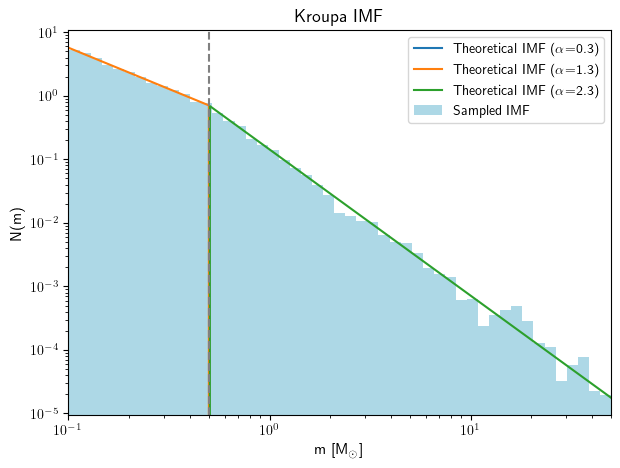

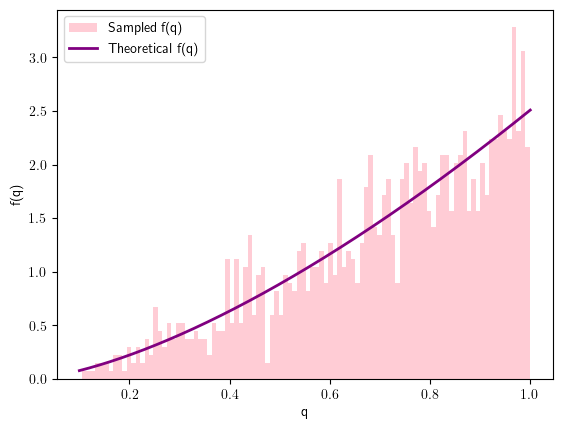

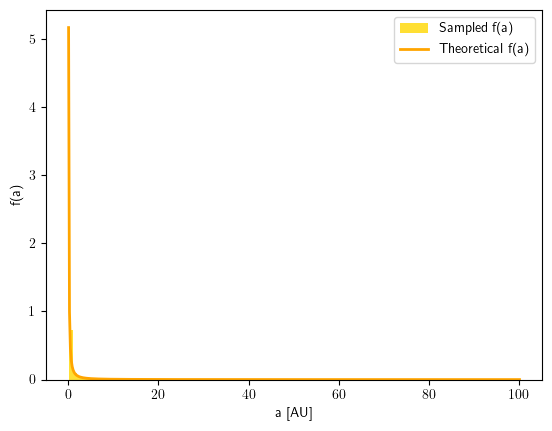

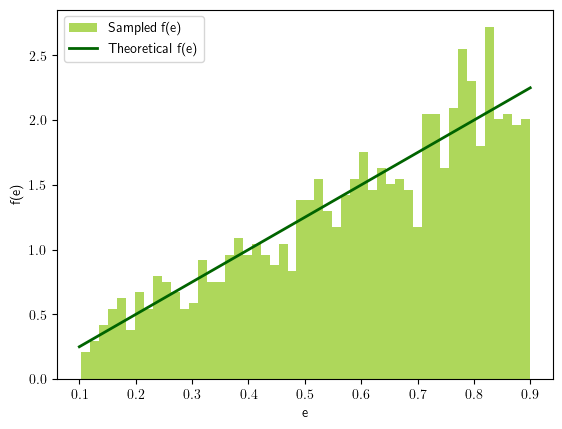

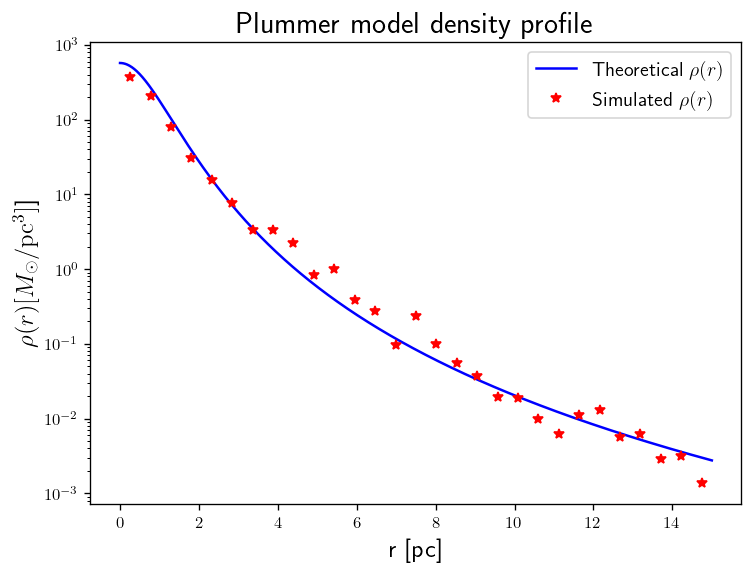

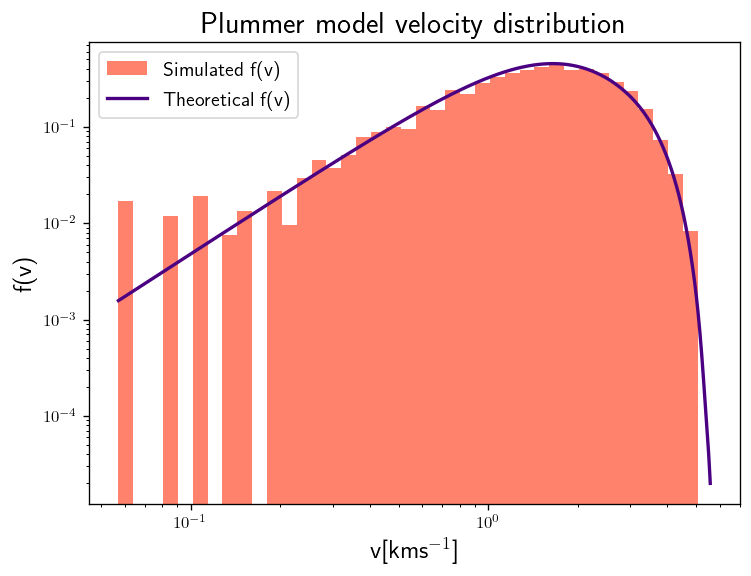

Virial ratio : 0.49999999999999994
Initial file saved in : initial_conditions.dat


In [12]:
mode_1 = 'rp'
mode_2 = 'q'

launcher = {
    'rp': lambda: main_program_random_pairing(N_tot=10000, f_b_percent=15, R=1.0, fractal_flag=False, seed=35),
    'q': lambda: main_program_q_distribution(N_tot=10000, f_b_percent=15, R=1.0, fractal_flag=False, seed=35)
}

Q_corrected, file_dat = launcher[mode_2]() # It executes the selected mode

print('Virial ratio :', Q_corrected)
print('Initial file saved in :', file_dat)